### This is a fixed point iteration loop to solve the Hamilton-Jacobi-Bellman PDE for the Neoclassical Growth Model with a convex-concave production function as in Skiba (1978) "Optimal Growth with a Convex-Concave Production Function"

Use "butterfly technology":
$$
    f(k) = \max(f_H(k),f_L(k))
$$
where:
$$
f_H(k) = A_H\max(k - \kappa,0)^\alpha
$$
$$
f_L(k) = A_Lk^\alpha
$$
Originally written by Greg Kaplan and Benjamin Moll. Rewritten in Python by Ted To.

In [1]:
# Import `pyplot`, `numpy` and the `shift` operator from `scipy.ndimage.interpolation`
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import shift
from scipy.sparse import spdiags, eye, linalg

In [2]:
%matplotlib inline

In [3]:
# Initialize model parameters

# coefficient of relative risk aversion
σ = 2
# capital share
α = 0.3
# discount rate
ρ = 0.05
# depreciation
δ = 0.05
AH = 0.6
AL = 0.4
κ = 2 #fixed cost

In [4]:
kssH = (α*AH/(ρ+δ))**(1/(1-α)) + κ
kstar = κ/(1-(AL/AH)**(1/α))

In [5]:
I = 1000
kmin = 0.001*kssH
kmax = 1.3*kssH
k = np.linspace(kmin,kmax,I)
dk = (kmax-kmin)/(I-1)

Text(0, 0.5, '$f(k)$')

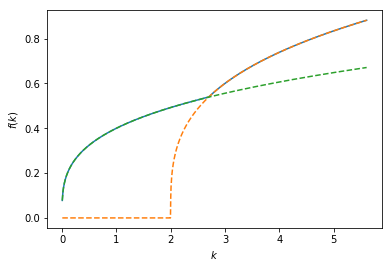

In [6]:
# production function
yH = [AH*max(k_val - κ,0)**α for k_val in k]
yL = [AL*k_val**α for k_val in k]
y = np.maximum(yH,yL)
plt.plot(k,y)
plt.plot(k,yH,'--')
plt.plot(k,yL,'--')
plt.xlabel('$k$')
plt.ylabel('$f(k)$')

In [7]:
maxit=1000
crit = 10e-6
Delta = 1000

In [8]:
# Initialize forward difference, backward difference and consumption grid

dVf = np.zeros(I)
dVb = np.zeros(I)
c = np.zeros(I)

In [9]:
# INITIAL GUESS

v0 = (k**α)**(1-σ)/(1-σ)/ρ
v = v0

In [10]:
# initialize distance
dist = np.zeros(maxit)

for n in range(maxit):
    V = v
    # forward difference
    dVf = shift((V-shift(V,1))/dk,-1)
    dVf[I-1] = (y[I-1] - δ*kmax)**(-σ) #state constraint, for stability
    # backward differencce
    dVb = (V-shift(V,1))/dk
    dVb[0] = (y[0] - δ*kmin)**(-σ) #state constraint, for stability
       
    # consumption and savings with forward difference
    cf = np.maximum(dVf,10e-10)**(-1/σ)
    muf = y - δ*k - cf
    Hf = cf**(1-σ)/(1-σ) + dVf*muf
    
    # consumption and savings with backward difference
    cb = np.maximum(dVb,10e-10)**(-1/σ)
    mub = y - δ*k - cb
    Hb = cb**(1-σ)/(1-σ) + dVb*mub
    
    # consumption and derivative of value function at steady state
    c0 = y - δ*k
    dV0 = np.maximum(c0,10e-10)**(-σ)
    H0 = c0**(1-σ)/(1-σ)
    
    # dV_upwind makes a choice of forward or backward differences based on
    # the sign of the drift    
    Ineither = (1-(muf>0)) * (1-(mub<0))
    Iunique = (mub<0)*(1-(muf>0)) + (1-(mub<0))*(muf>0)
    Iboth = (mub<0)*(muf>0)
    Ib = Iunique*(mub<0) + Iboth*(Hb>=Hf)
    If = Iunique*(muf>0) + Iboth*(Hf>=Hb)
    I0 = Ineither
    
    # consumption
    c  = cf*If + cb*Ib + c0*I0
    u = c**(1-σ)/(1-σ)
    
    # CONSTRUCT MATRIX
    X = -Ib*mub/dk
    Y = -If*muf/dk + Ib*mub/dk
    Z = If*muf/dk
    
    #sparse matrix: faster
    A =spdiags(Y,0,I,I)+spdiags(X[1:I],-1,I,I)+spdiags(np.insert(Z,0,0),1,I,I);
    B = (ρ + 1/Delta)*eye(I) - A
    b = u + V/Delta
    V = linalg.spsolve(B,b) #SOLVE SYSTEM OF EQUATIONS
    Vchange = V - v
    v = V

    dist[n] = max(abs(Vchange))
    if dist[n]<crit:
        print('Value Function Converged, Iteration =', n)
        break

Value Function Converged, Iteration =  111


Text(0, 0.5, '$||V^{n+1} - V^n||$')

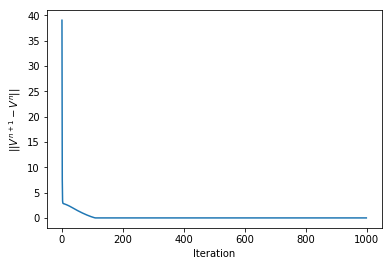

In [11]:
plt.plot(dist)
plt.xlabel('Iteration')
plt.ylabel('$||V^{n+1} - V^n||$')

In [12]:
kdot = y - δ*k - c
dV_Upwind = dVf*If + dVb*Ib + dV0*I0
Verr = c**(1-σ)/(1-σ) + dV_Upwind*kdot - ρ*V

(0.004315661138092787, 5.610359479520624)

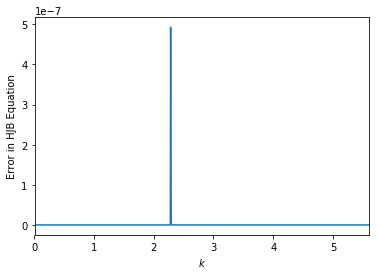

In [13]:
plt.plot(k,Verr)
plt.xlabel('$k$')
plt.ylabel('Error in HJB Equation')
plt.xlim(kmin, kmax)

Text(0, 0.5, '$f(k)$')

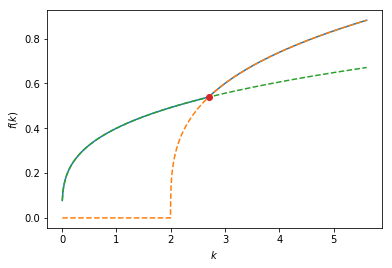

In [14]:
plt.plot(k,y,k,yH,'--',k,yL,'--',kstar,AL*kstar**α,'o')
plt.xlabel('$k$')
plt.ylabel('$f(k)$')

(0.004315661138092787, 5.610359479520624)

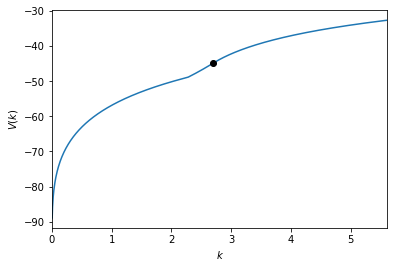

In [15]:
k_ind = np.argmin(abs(kstar-k))

plt.plot(k,V)
plt.plot(kstar,V[k_ind],'ok')
plt.xlabel('$k$')
plt.ylabel('$V(k)$')
plt.xlim(kmin, kmax)

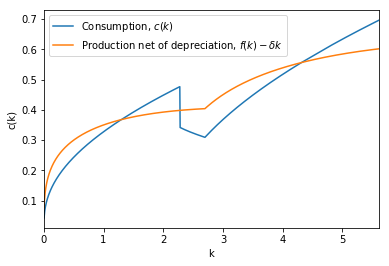

In [16]:
plt.plot(k,c,label='Consumption, $c(k)$')
plt.plot(k,y-δ*k, label='Production net of depreciation, $f(k) - \delta k$')
plt.xlabel('k')
plt.ylabel('c(k)')
plt.xlim(kmin, kmax)
plt.legend()

(0.004315661138092787, 5.610359479520624)

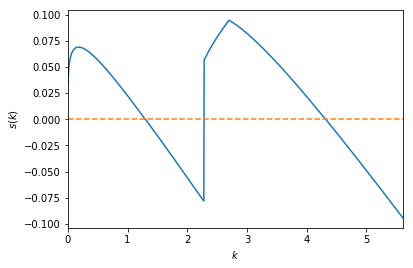

In [17]:
plt.plot(k,kdot,k,np.zeros(I),'--')
plt.xlabel('$k$')
plt.ylabel('$s(k)$')
plt.xlim(kmin, kmax)